# How well could Cubic Zirconias' prices be predicted?

![image](gems.jpg)

## Introduction
Cubic Zirconia is an inexpensive diamond alternative with many of the same qualities as a diamond. Cubic zirconia is classified as a diamond simulant - a stone that looks similar to natural diamonds, but is made of different material. Natural and lab-grown diamonds are made of carbon, while cubic zirconia is made of *zirconium dioxide (ZrO2)*. The cubic part of the name comes from the fact that the stone has a cubic crystalline form. Diamonds also have a cubic crystalline form, so cubic zirconia is a great diamond lookalike. 

A Cubic Zirconia manufacturing company is interested in knowing the differences between higher profitable stones and lower profitable stones. 



## Data

The dataset contains the prices and other attributes of almost 27,000 cubic zirconia 

### Data Dictionary
|Variable Name|Description|
|:------|:------|
|carat| Carat weight of the cubic zirconia.|
|cut| Describe the cut quality of the cubic zirconia. Quality is increasing order Fair, Good, Very Good, Premium, Ideal.|
|color| Colour of the cubic zirconia.With D being the best and J the worst.|
|clarity| cubic zirconia Clarity refers to the absence of the Inclusions and Blemishes. (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3|
|depth| The Height of a cubic zirconia, measured from the Culet to the table, divided by its average Girdle Diameter.|
|table| The Width of the cubic zirconia's Table expressed as a Percentage of its Average Diameter.|
|x| Length of the cubic zirconia in mm.|
|y| Width of the cubic zirconia in mm.|
|z| Height of the cubic zirconia in mm.|
|**price**| Price of the stone|

### Resources
1. [Information about Gemstone's specifications and features by Brialliant Earth](https://www.brilliantearth.com/diamond/buying-guide/carat/?gclid=Cj0KCQjwl92XBhC7ARIsAHLl9an3M1BVcdpYQzZX08KIkOpJLcEo2VFAh0VFpSUsvATY73afBxGyVO4aAkYJEALw_wcB)

2. [Difference between Cubic Zirconia and Diamond Explained](https://www.creditdonkey.com/cubic-zirconia-diamond.html)

3. [The Dataset](https://www.kaggle.com/datasets/colearninglounge/gemstone-price-prediction?select=cubic_zirconia.csv)

## Goal 

Helping the company in predicting the price for the stone on the basis of the details given in the dataset so it can distinguish between higher profitable stones and lower profitable stones so as to have a better profit share.

---

In [46]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Importing ML Libs
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib


## Reading in the dataset and its Initial Analysis

In [3]:
# Reading in the dataset
data = pd.read_csv('cubic_zirconia.csv', 
                   index_col=0)

# Peak
data.head()

carat        cut color clarity  depth  table     x     y     z  price
1   0.30      Ideal     E     SI1   62.1   58.0  4.27  4.29  2.66    499
2   0.33    Premium     G      IF   60.8   58.0  4.42  4.46  2.70    984
3   0.90  Very Good     E    VVS2   62.2   60.0  6.04  6.12  3.78   6289
4   0.42      Ideal     F     VS1   61.6   56.0  4.82  4.80  2.96   1082
5   0.31      Ideal     F    VVS1   60.4   59.0  4.35  4.43  2.65    779

In [4]:
data.shape

(26967, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26967 entries, 1 to 26967
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    26967 non-null  float64
 1   cut      26967 non-null  object 
 2   color    26967 non-null  object 
 3   clarity  26967 non-null  object 
 4   depth    26270 non-null  float64
 5   table    26967 non-null  float64
 6   x        26967 non-null  float64
 7   y        26967 non-null  float64
 8   z        26967 non-null  float64
 9   price    26967 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 2.3+ MB


- There are 3 object, and 7 numerical features
- Also, apparently, there are some null values

In [6]:
data.isnull().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

- `depth` is the only feature that contains NaNs and there are around 697 NaN values in this column

In [7]:
data.duplicated().sum()

34

- Also, there are 34 duplicated samples in the dataset

Specifically for the columns that are of Object dtypes, the following is their composition

In [8]:
[data[col].value_counts(normalize=True)*100 for col in data.select_dtypes(include='O')]

[Ideal        40.108280
 Premium      25.583120
 Very Good    22.360663
 Good          9.051804
 Fair          2.896132
 Name: cut, dtype: float64,
 G    20.992324
 E    18.233396
 F    17.536248
 H    15.211184
 D    12.400341
 I    10.275522
 J     5.350985
 Name: color, dtype: float64,
 SI1     24.366819
 VS2     22.616531
 SI2     16.965180
 VS1     15.177810
 VVS2     9.385545
 VVS1     6.819446
 IF       3.315163
 I1       1.353506
 Name: clarity, dtype: float64]

In [9]:
data.describe()

carat         depth         table             x             y  \
count  26967.000000  26270.000000  26967.000000  26967.000000  26967.000000   
mean       0.798375     61.745147     57.456080      5.729854      5.733569   
std        0.477745      1.412860      2.232068      1.128516      1.166058   
min        0.200000     50.800000     49.000000      0.000000      0.000000   
25%        0.400000     61.000000     56.000000      4.710000      4.710000   
50%        0.700000     61.800000     57.000000      5.690000      5.710000   
75%        1.050000     62.500000     59.000000      6.550000      6.540000   
max        4.500000     73.600000     79.000000     10.230000     58.900000   

                  z         price  
count  26967.000000  26967.000000  
mean       3.538057   3939.518115  
std        0.720624   4024.864666  
min        0.000000    326.000000  
25%        2.900000    945.000000  
50%        3.520000   2375.000000  
75%        4.040000   5360.000000  
max       31.800000  18818.000000

- The dataset is spread across different scales. It can be seen that `carat` lies within 0-10, `depth`, and `table` within 10-100 etc.
- It can be seen that the lowest values from `x`, `y`, and `z` are 0! It is not possible. It should be recalled that each of these features represent physical dimension of a gem and dimension can not be equal to 0 in this case! 
    - This shall be addressed in Data Cleaning

---
## Data Cleaning

In [10]:
data = data.drop_duplicates()
print('After removing duplicates, remaining samples are {}'.format(data.shape[0]))

After removing duplicates, remaining samples are 26933


Also, lets remove the samples with null values.

In [11]:
data = data.dropna(subset='depth')
data.isnull().sum().sum()

0

To handle categorical/Object features better, numbers can be provided. Since all of the columns are Ordinal in nature, OHE or random label encoding might not be the best options. 

In [12]:
data.head()

carat        cut color clarity  depth  table     x     y     z  price
1   0.30      Ideal     E     SI1   62.1   58.0  4.27  4.29  2.66    499
2   0.33    Premium     G      IF   60.8   58.0  4.42  4.46  2.70    984
3   0.90  Very Good     E    VVS2   62.2   60.0  6.04  6.12  3.78   6289
4   0.42      Ideal     F     VS1   61.6   56.0  4.82  4.80  2.96   1082
5   0.31      Ideal     F    VVS1   60.4   59.0  4.35  4.43  2.65    779

Checking where any dimension, (`x`, `y`, or `z`) is equal to zero

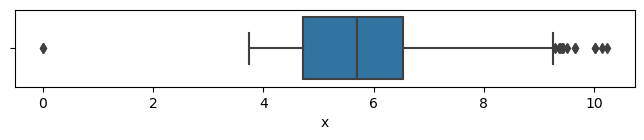

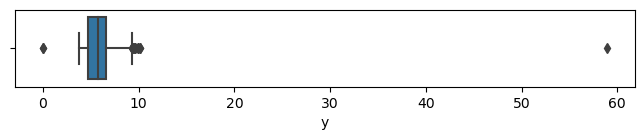

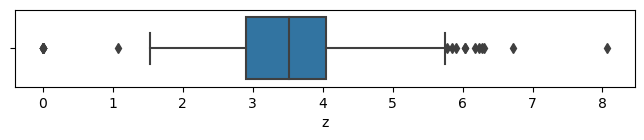

In [13]:
dimension_cols = ['x', 'y', 'z']
for col in dimension_cols:
    plt.figure(figsize=(8,1))
    sns.boxplot(data=data, x=col)
    plt.show()

- Clearly there are a few values where either of the dimensions is zero. 

Lets remove these points right away

In [14]:
# Data points where either of dimension is 0
data.loc[(data[dimension_cols]==0).any(axis=1)]

carat      cut color clarity  depth  table     x     y    z  price
5822    0.71     Good     F     SI2   64.1   60.0  0.00  0.00  0.0   2130
6035    2.02  Premium     H     VS2   62.7   53.0  8.02  7.95  0.0  18207
10828   2.20  Premium     H     SI1   61.2   59.0  8.42  8.37  0.0  17265
12499   2.18  Premium     H     SI2   59.4   61.0  8.49  8.45  0.0  12631
12690   1.10  Premium     G     SI2   63.0   59.0  6.50  6.47  0.0   3696
17507   1.14     Fair     G     VS1   57.5   67.0  0.00  0.00  0.0   6381
18195   1.01  Premium     H      I1   58.1   59.0  6.66  6.60  0.0   3167
23759   1.12  Premium     G      I1   60.4   59.0  6.71  6.67  0.0   2383

In [15]:
# Removing these points
data = data.drop(data.loc[(data[dimension_cols]==0).any(axis=1)].index, axis=0).reset_index(drop=True)

In [16]:
# Mapper Dictionary for cut
dict_cut = {'Ideal':5, 
            'Premium':4, 
            'Very Good':3, 
            'Good':2, 
            'Fair':1}

In [17]:
# Mapper Dicionary for color
dict_color = dict(zip(sorted(data['color'].unique()), 
                      [i for i in range(len(data['color'].unique()),0,-1)]))

In [18]:
# Mapper Dictionary for clarity
clarity_ordered = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']
dict_clarity = dict(zip(clarity_ordered, [i for i in range(len(clarity_ordered),0,-1)]))

In [19]:
def apply_mapper(df ,col, mapper):
    '''
    Applies mapping to a col
    
    Args: 
        df: dataframe
        col: the column
        mapper: mapping dictionary
    Returns:
        Dataframe with mapped columns
    '''
    df[str(col)+('_mapped')] = df[col].replace(mapper)
    return df

In [20]:
# Lists of object columns and their mapping dictionaries
obj_cols = ['cut', 'color', 'clarity']
obj_maps = [dict_cut, dict_color, dict_clarity]

# Zipping each pair and applying the function
for pair in zip(obj_cols, obj_maps):
    df = apply_mapper(data, pair[0], pair[1])

In [21]:
df.head()

carat        cut color clarity  depth  table     x     y     z  price  \
0   0.30      Ideal     E     SI1   62.1   58.0  4.27  4.29  2.66    499   
1   0.33    Premium     G      IF   60.8   58.0  4.42  4.46  2.70    984   
2   0.90  Very Good     E    VVS2   62.2   60.0  6.04  6.12  3.78   6289   
3   0.42      Ideal     F     VS1   61.6   56.0  4.82  4.80  2.96   1082   
4   0.31      Ideal     F    VVS1   60.4   59.0  4.35  4.43  2.65    779   

   cut_mapped  color_mapped  clarity_mapped  
0           5             6               5  
1           4             4              10  
2           3             6               8  
3           5             5               7  
4           5             5               9

In [22]:
# Dropping the original object columns
df = df.drop(obj_cols, axis=1)

# peak
df.head()

carat  depth  table     x     y     z  price  cut_mapped  color_mapped  \
0   0.30   62.1   58.0  4.27  4.29  2.66    499           5             6   
1   0.33   60.8   58.0  4.42  4.46  2.70    984           4             4   
2   0.90   62.2   60.0  6.04  6.12  3.78   6289           3             6   
3   0.42   61.6   56.0  4.82  4.80  2.96   1082           5             5   
4   0.31   60.4   59.0  4.35  4.43  2.65    779           5             5   

   clarity_mapped  
0               5  
1              10  
2               8  
3               7  
4               9

---
## Data Analysis

In [23]:
df.describe()

carat         depth         table             x             y  \
count  26228.000000  26228.000000  26228.000000  26228.000000  26228.000000   
mean       0.797425     61.745573     57.455216      5.728685      5.732539   
std        0.476534      1.411824      2.230013      1.125010      1.164034   
min        0.200000     50.800000     49.000000      3.730000      3.710000   
25%        0.400000     61.000000     56.000000      4.710000      4.720000   
50%        0.700000     61.800000     57.000000      5.690000      5.700000   
75%        1.050000     62.500000     59.000000      6.540000      6.540000   
max        4.500000     73.600000     79.000000     10.230000     58.900000   

                  z         price    cut_mapped  color_mapped  clarity_mapped  
count  26228.000000  26228.000000  26228.000000  26228.000000    26228.000000  
mean       3.537417   3934.616288      3.910210      4.399192        6.056199  
std        0.695979   4018.196388      1.113075      1.704753        1.647296  
min        1.070000    326.000000      1.000000      1.000000        3.000000  
25%        2.900000    945.000000      3.000000      3.000000        5.000000  
50%        3.520000   2373.000000      4.000000      4.000000        6.000000  
75%        4.040000   5355.250000      5.000000      6.000000        7.000000  
max        8.060000  18818.000000      5.000000      7.000000       10.000000

<Figure size 1000x1000 with 0 Axes>

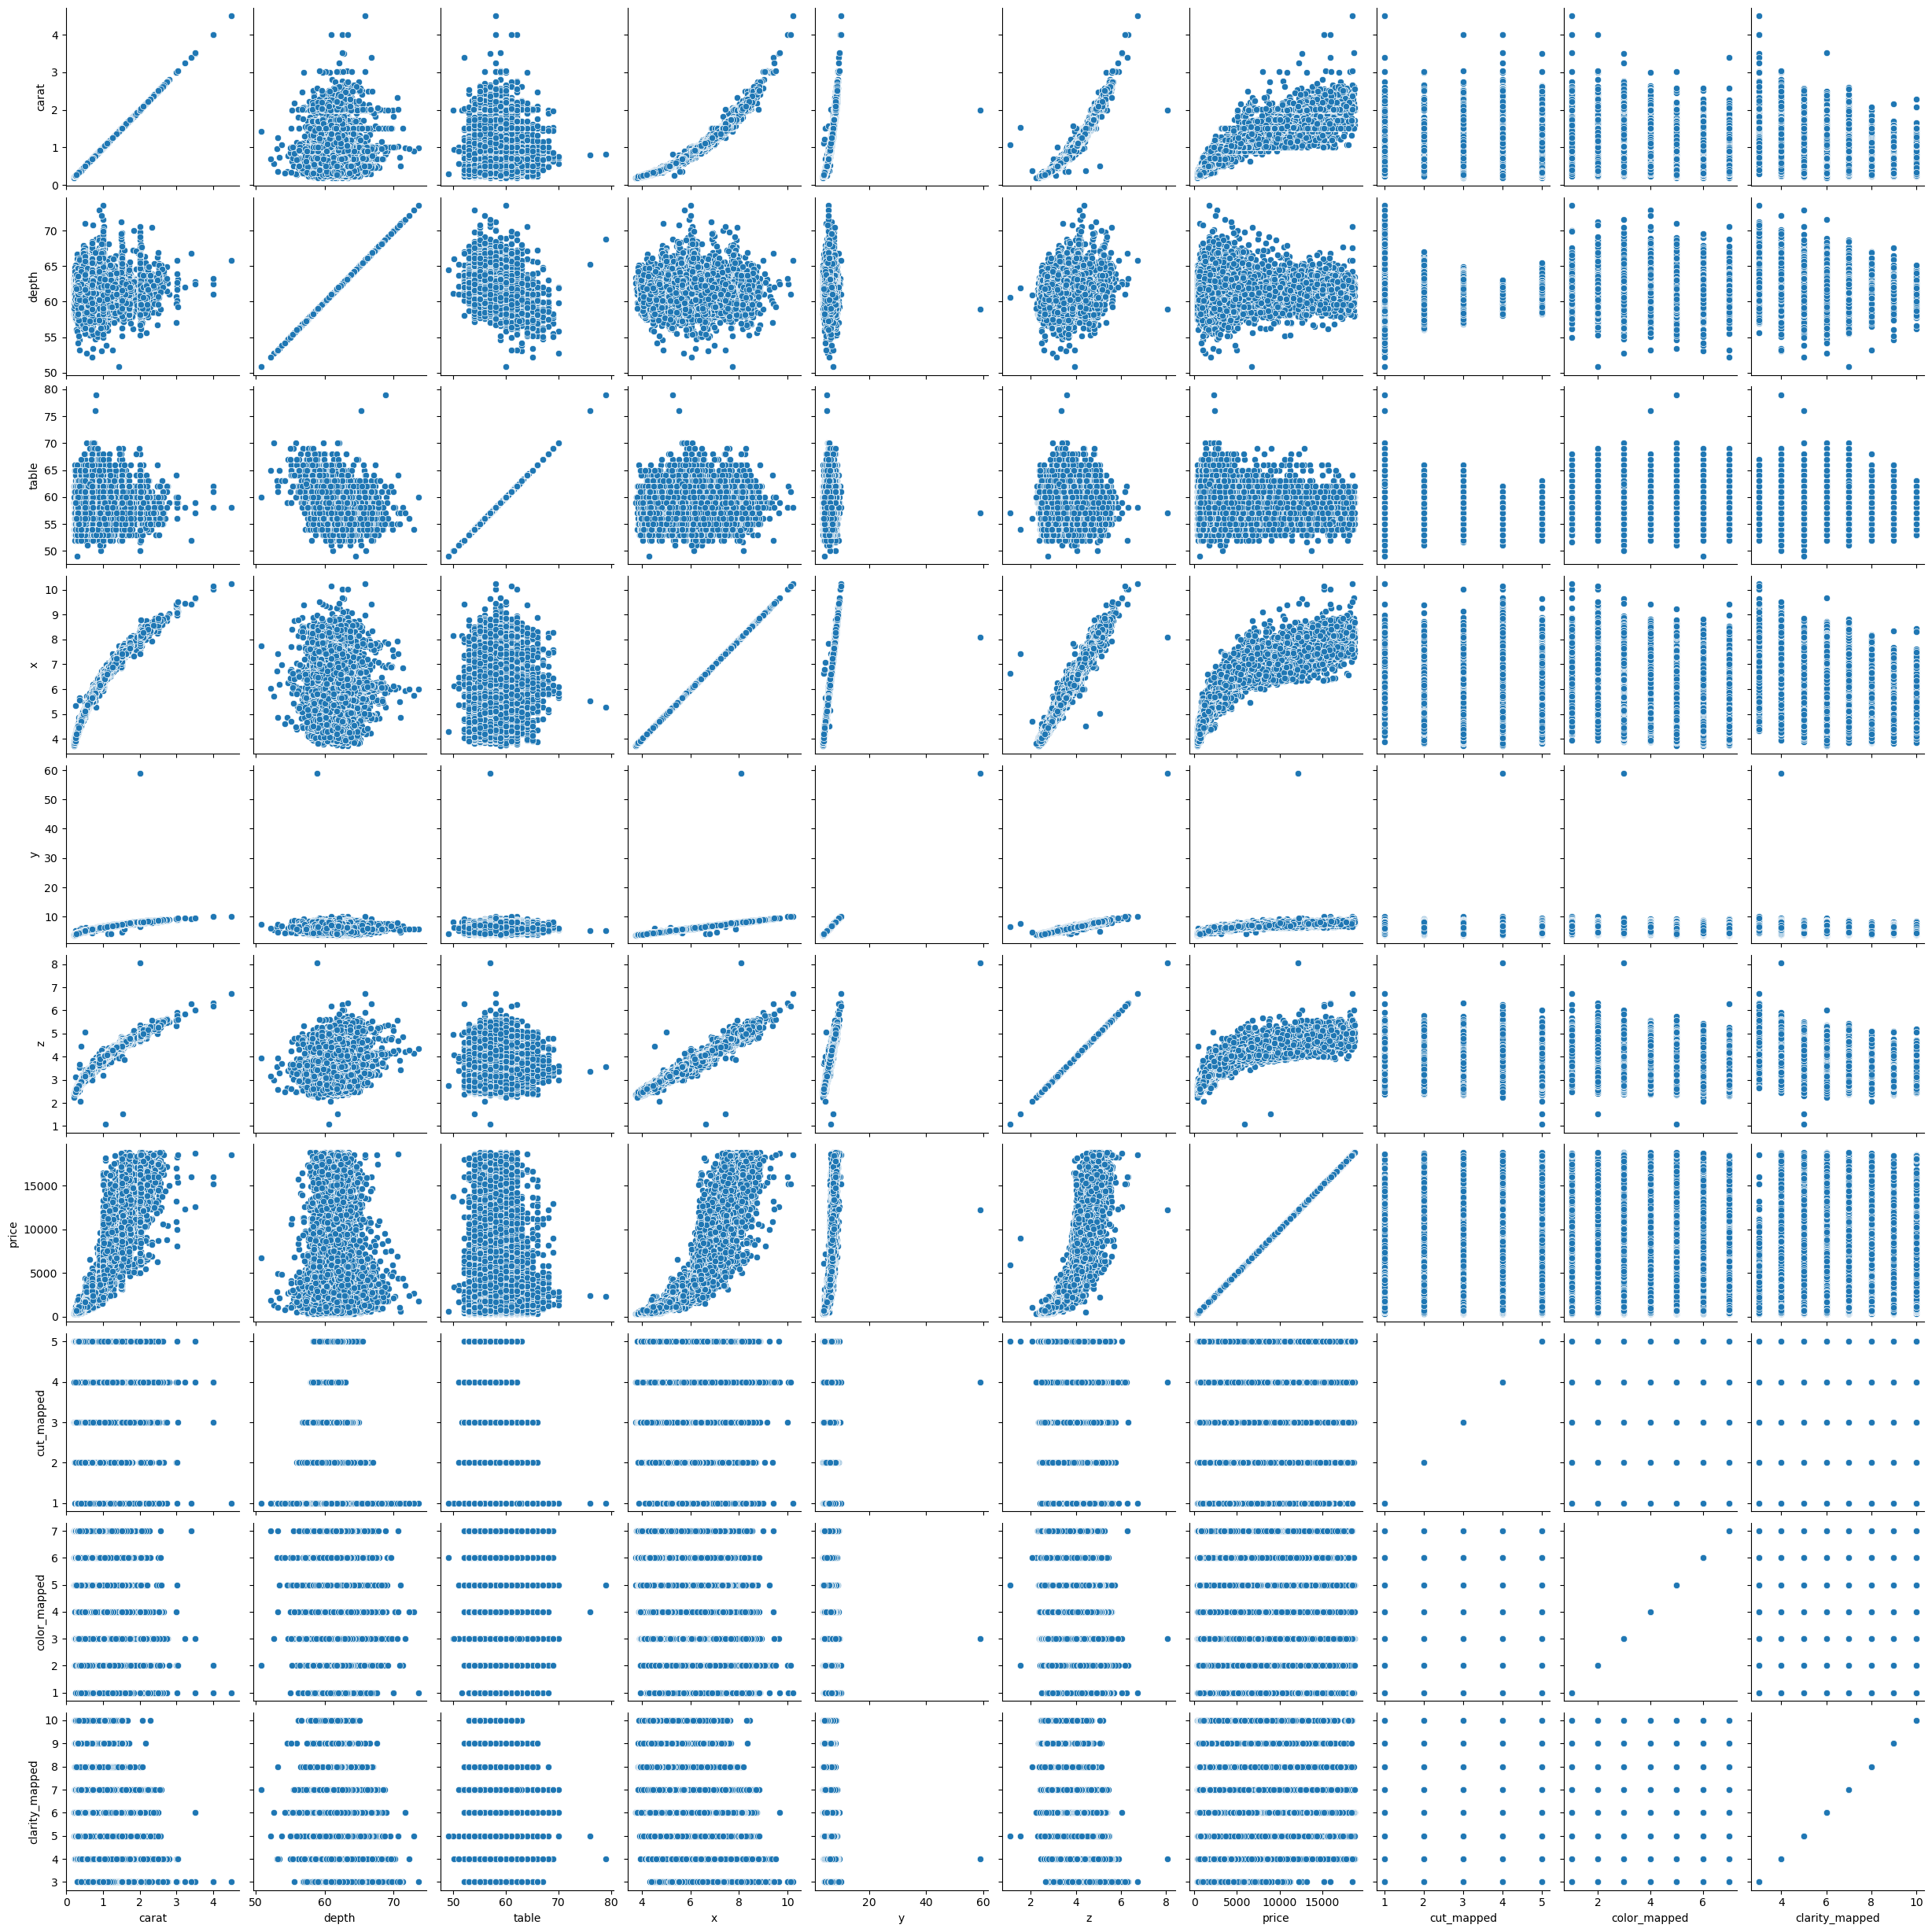

In [24]:
# Checking the Distributions 
plt.figure(figsize=(10,10))
sns.pairplot(df, 
             kind='scatter', 
             diag_kind=None)
plt.show()

<Figure size 1000x1000 with 0 Axes>

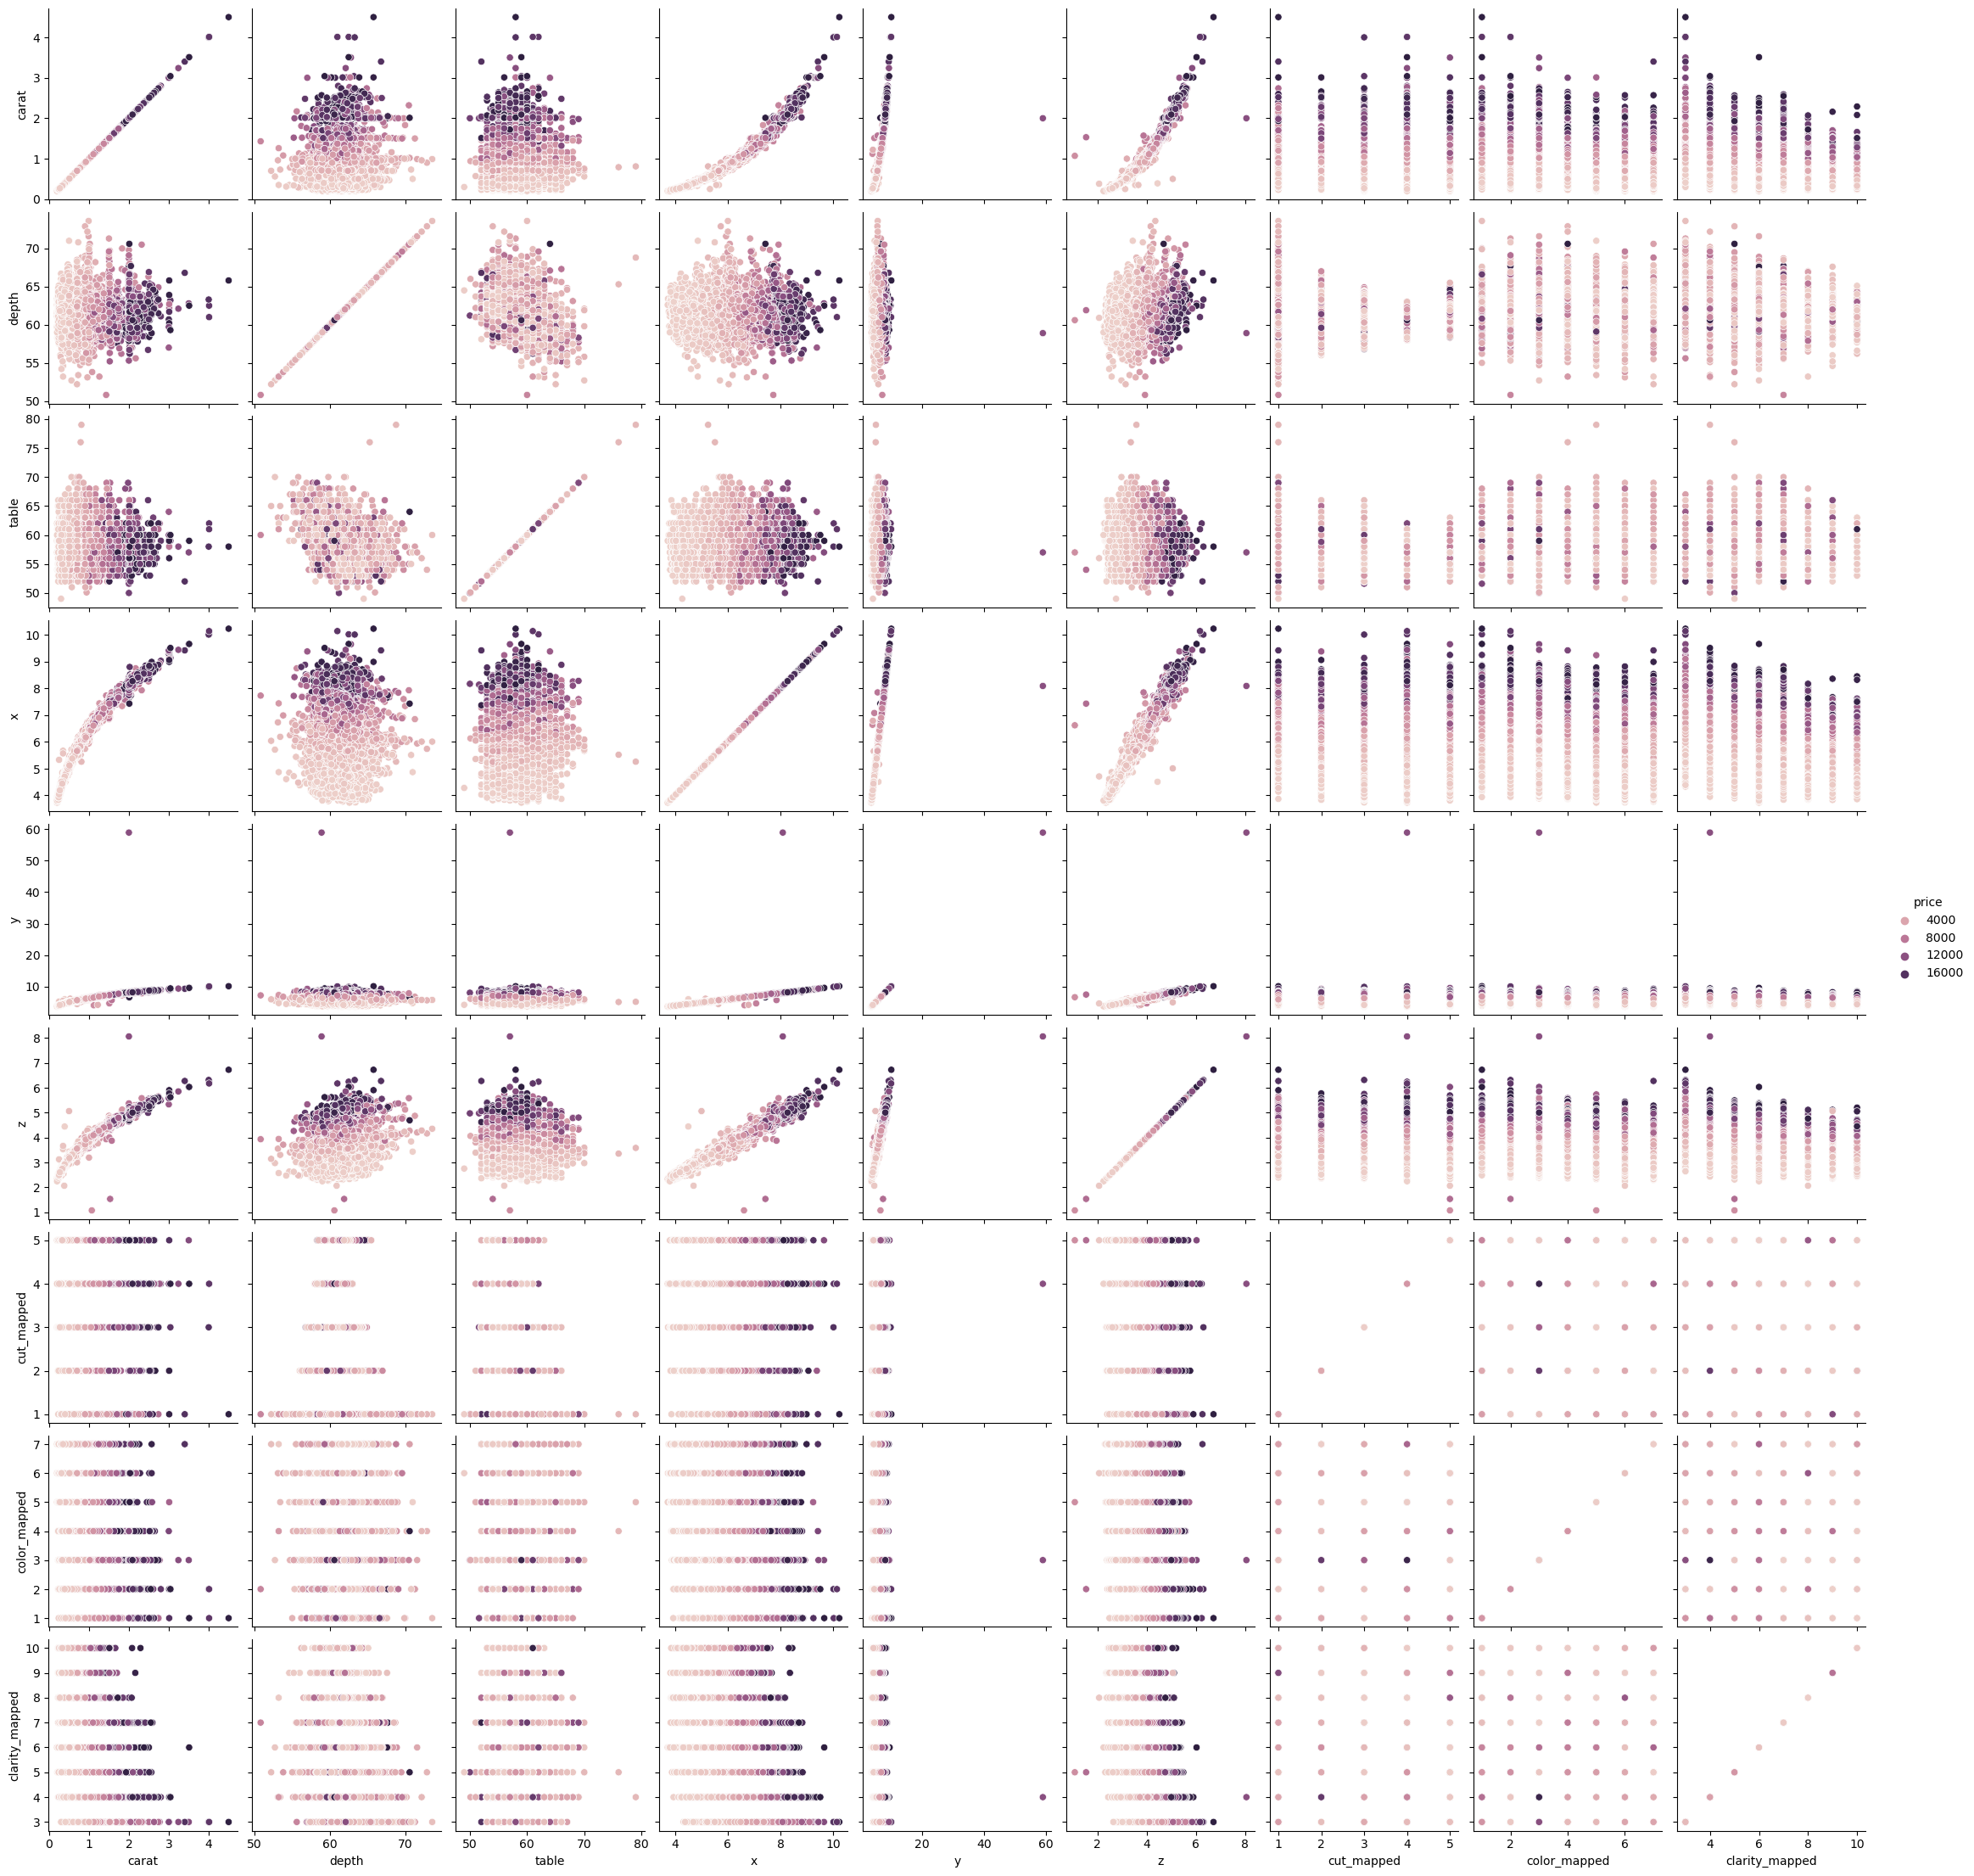

In [25]:
# Checking the Distributions with the target as hue
plt.figure(figsize=(10,10))
sns.pairplot(df, 
             kind='scatter', 
             diag_kind=None, 
             hue='price')
plt.show()

<Figure size 200x300 with 0 Axes>

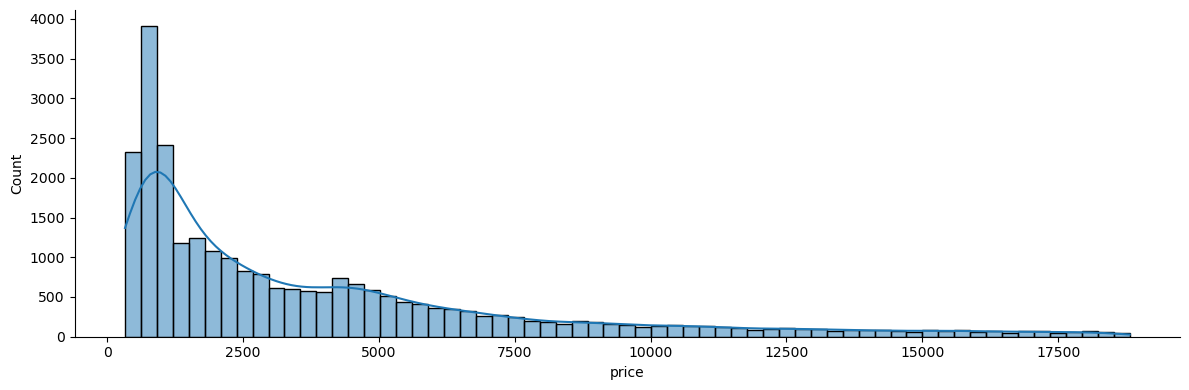

In [27]:
# The Target Variable
plt.figure(figsize=(2,3))
sns.displot(df, x='price', kde=True, height=4, aspect=3)
plt.show()

- The target variable seems to be severely left-skewed

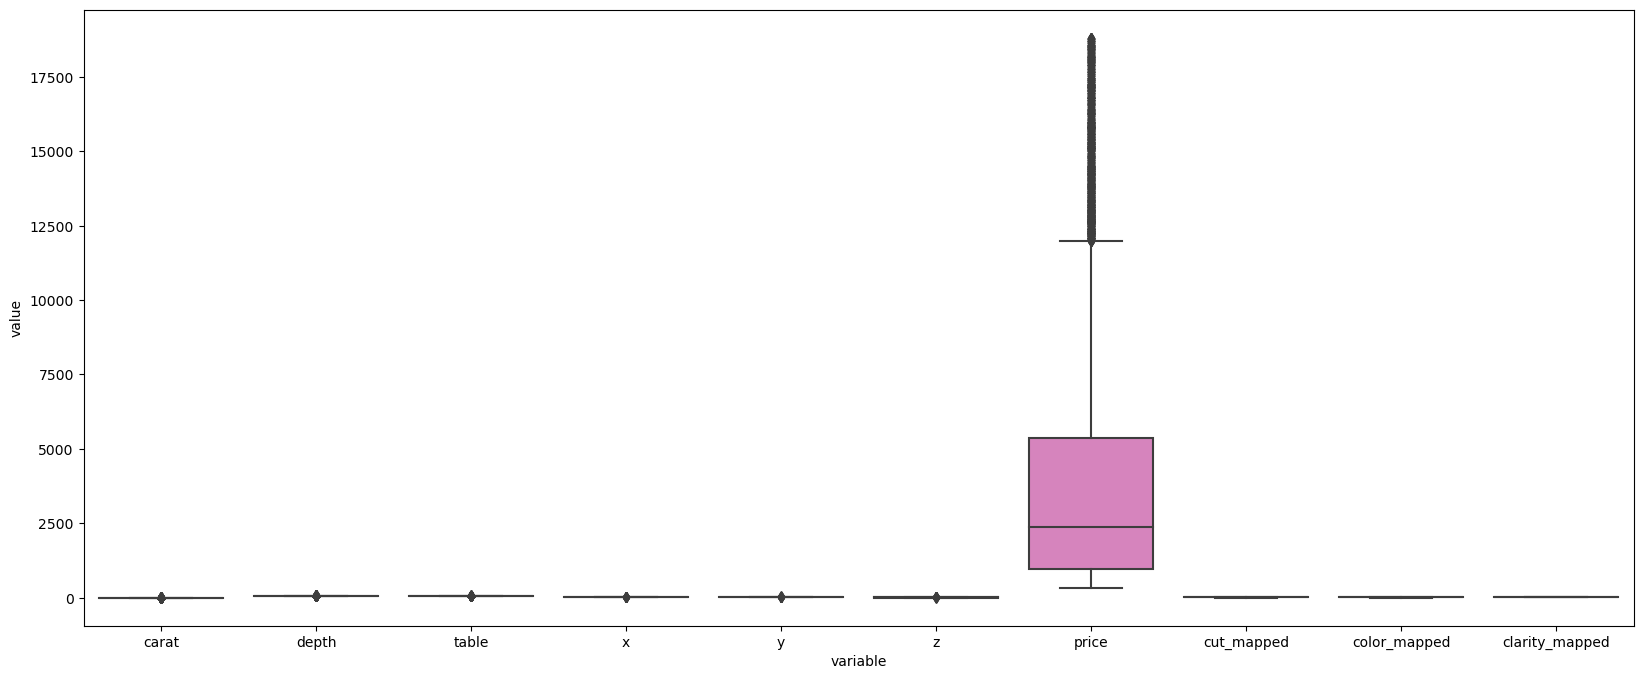

In [28]:
# Melting Dataframe 
df_melted = df.melt()

# Figure
plt.figure(figsize=(20,8))
sns.boxplot(x='variable', 
            y='value', 
            data=df_melted)
plt.show()

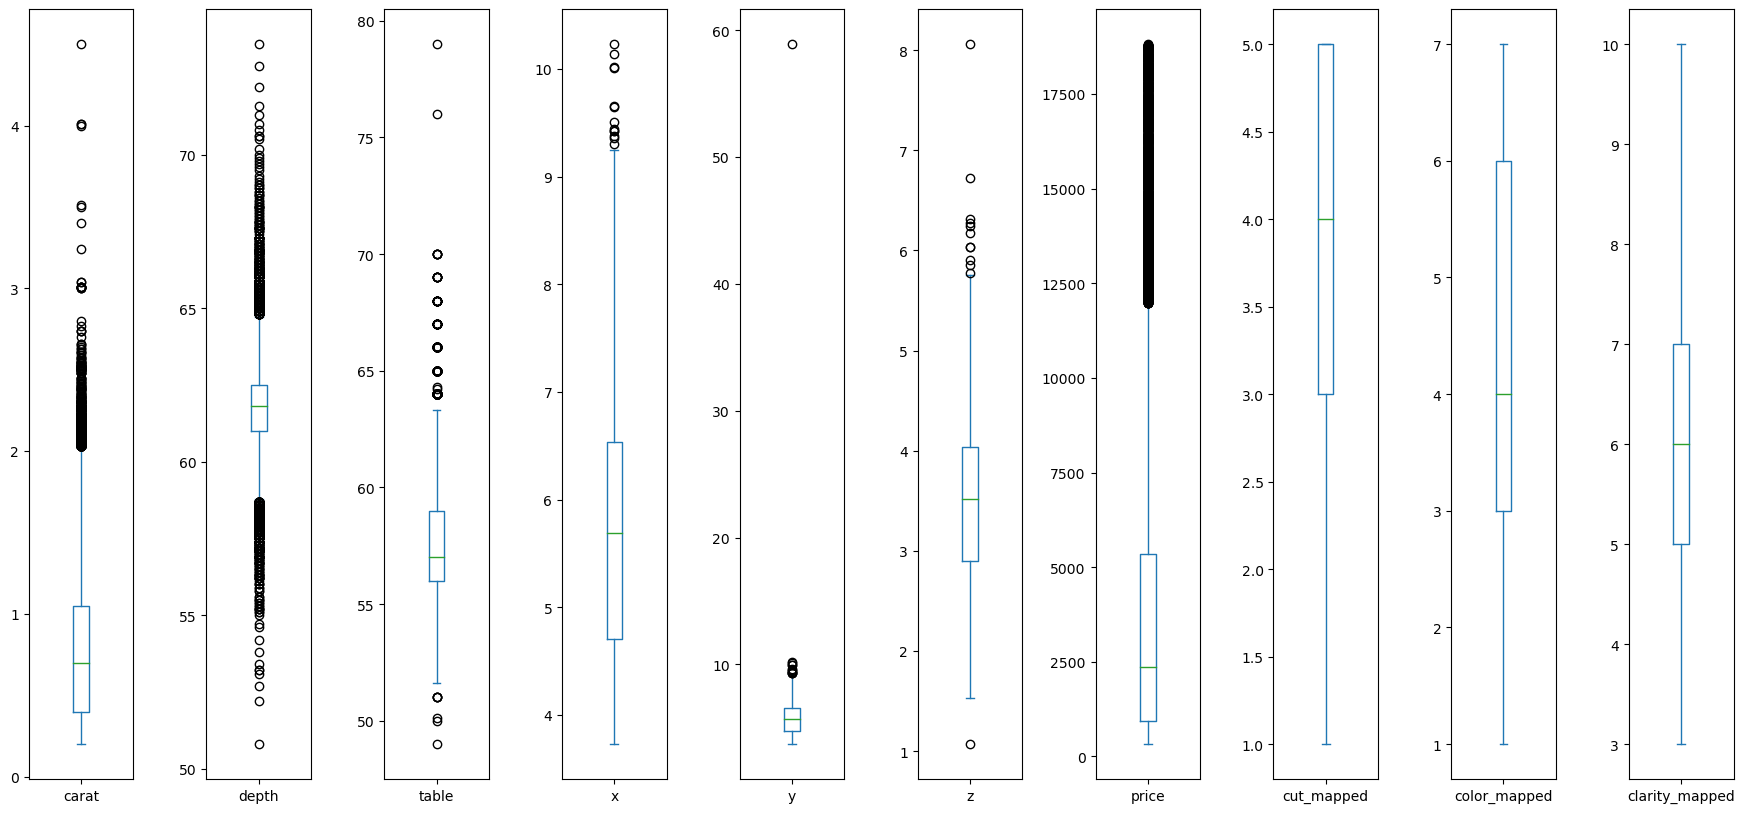

In [29]:
df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(22, 10)
)

# increase spacing between subplots
plt.subplots_adjust(wspace=0.7) 
plt.show()

- Certainly, there are lots of Outliers present in most of the variables, specially the continuous ones

In [30]:
def outliers(data, col, thresh=3):
    mean, std = data[col].mean(), data[col].std()
    cutoff = std*thresh
    lower, upper = mean - cutoff, mean+cutoff
    outliers = [val for val in data[col] if val < lower or val > upper]
    return outliers


In [31]:
# Gathering all independent variables
features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_mapped', 'color_mapped', 'clarity_mapped']

# Number of Outliers with thresh setting
for col in features:
    print(col, ':', len(outliers(df, col, thresh=2.7)))

carat : 409
depth : 527
table : 308
x : 41
y : 24
z : 66
cut_mapped : 0
color_mapped : 0
clarity_mapped : 0


- I have found that keeping a thresh that is too low causes losing too much data. After some hit and trial, a thresh of 2.7 seems to be an appropriate choice. This can be configured later as well

In [32]:
print('Before removal of Outliers:', df.shape[0])

# Making a copy of data
df1 = df.copy()
my_outliers = []
# Collecting indices
for col in features:
    # Collecting indices for each column
    outlying_items = outliers(df1, col, thresh=2.7)
    indices = df1[df1[col].isin(outlying_items)].index.tolist()
    # Appending all these in my_ouliers list
    for item in indices:
        my_outliers.append(item)
print('After removal of these: ', df1.shape[0] - len(set(my_outliers)))

Before removal of Outliers: 26228
After removal of these:  25063


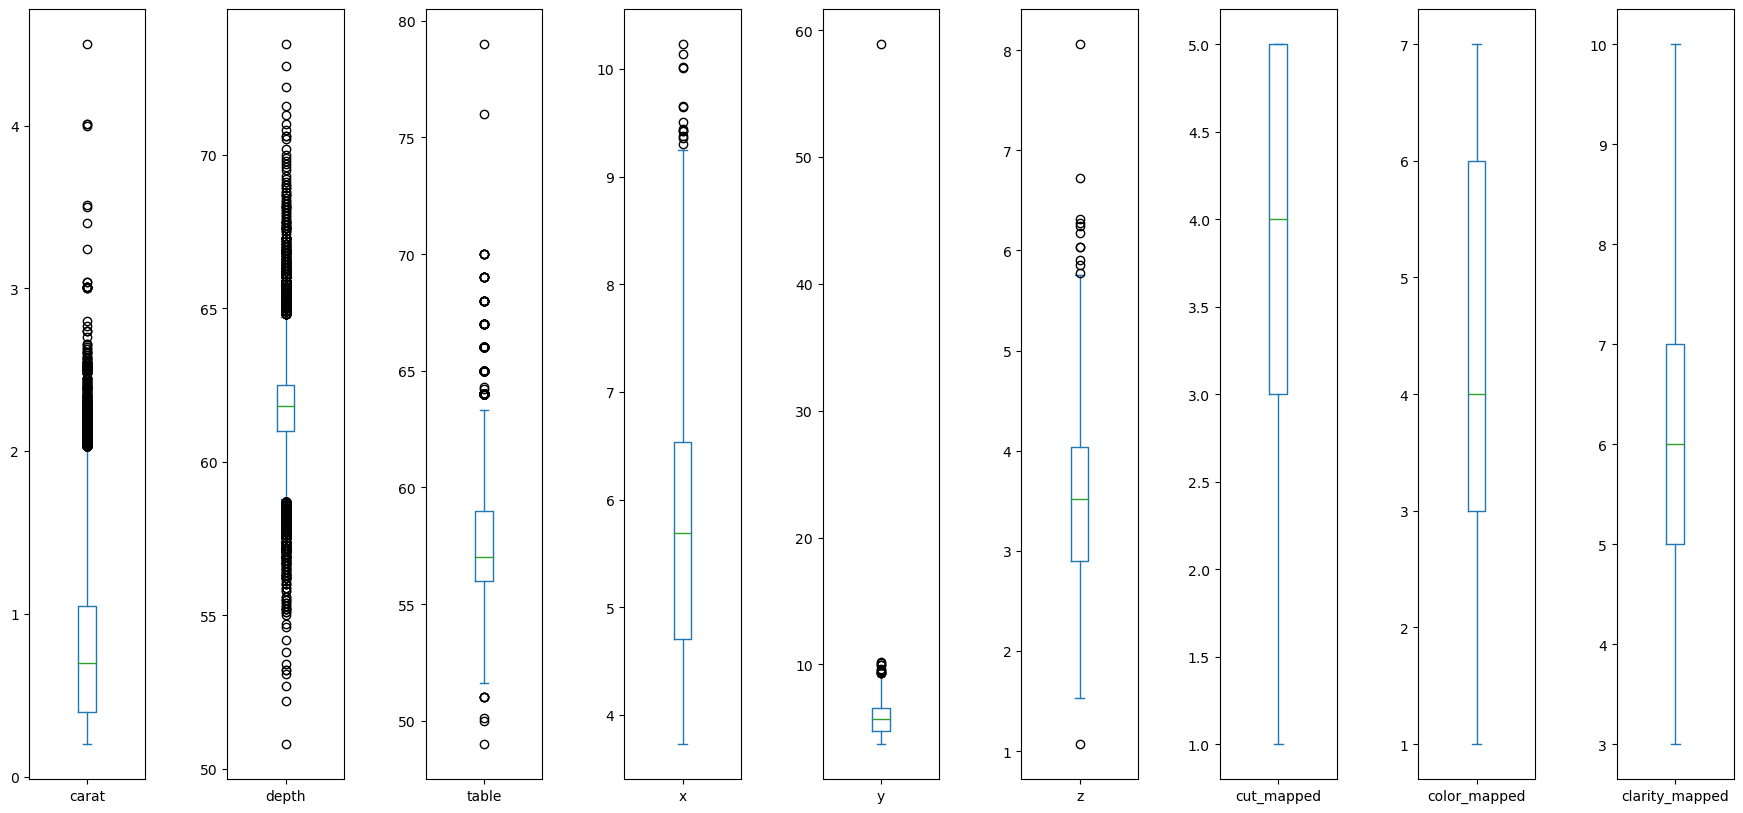

In [33]:
df1.drop('price', axis=1).plot(
                                kind='box', 
                                subplots=True, 
                                sharey=False, 
                                figsize=(22, 10)
)

# increase spacing between subplots
plt.subplots_adjust(wspace=0.7) 
plt.show()

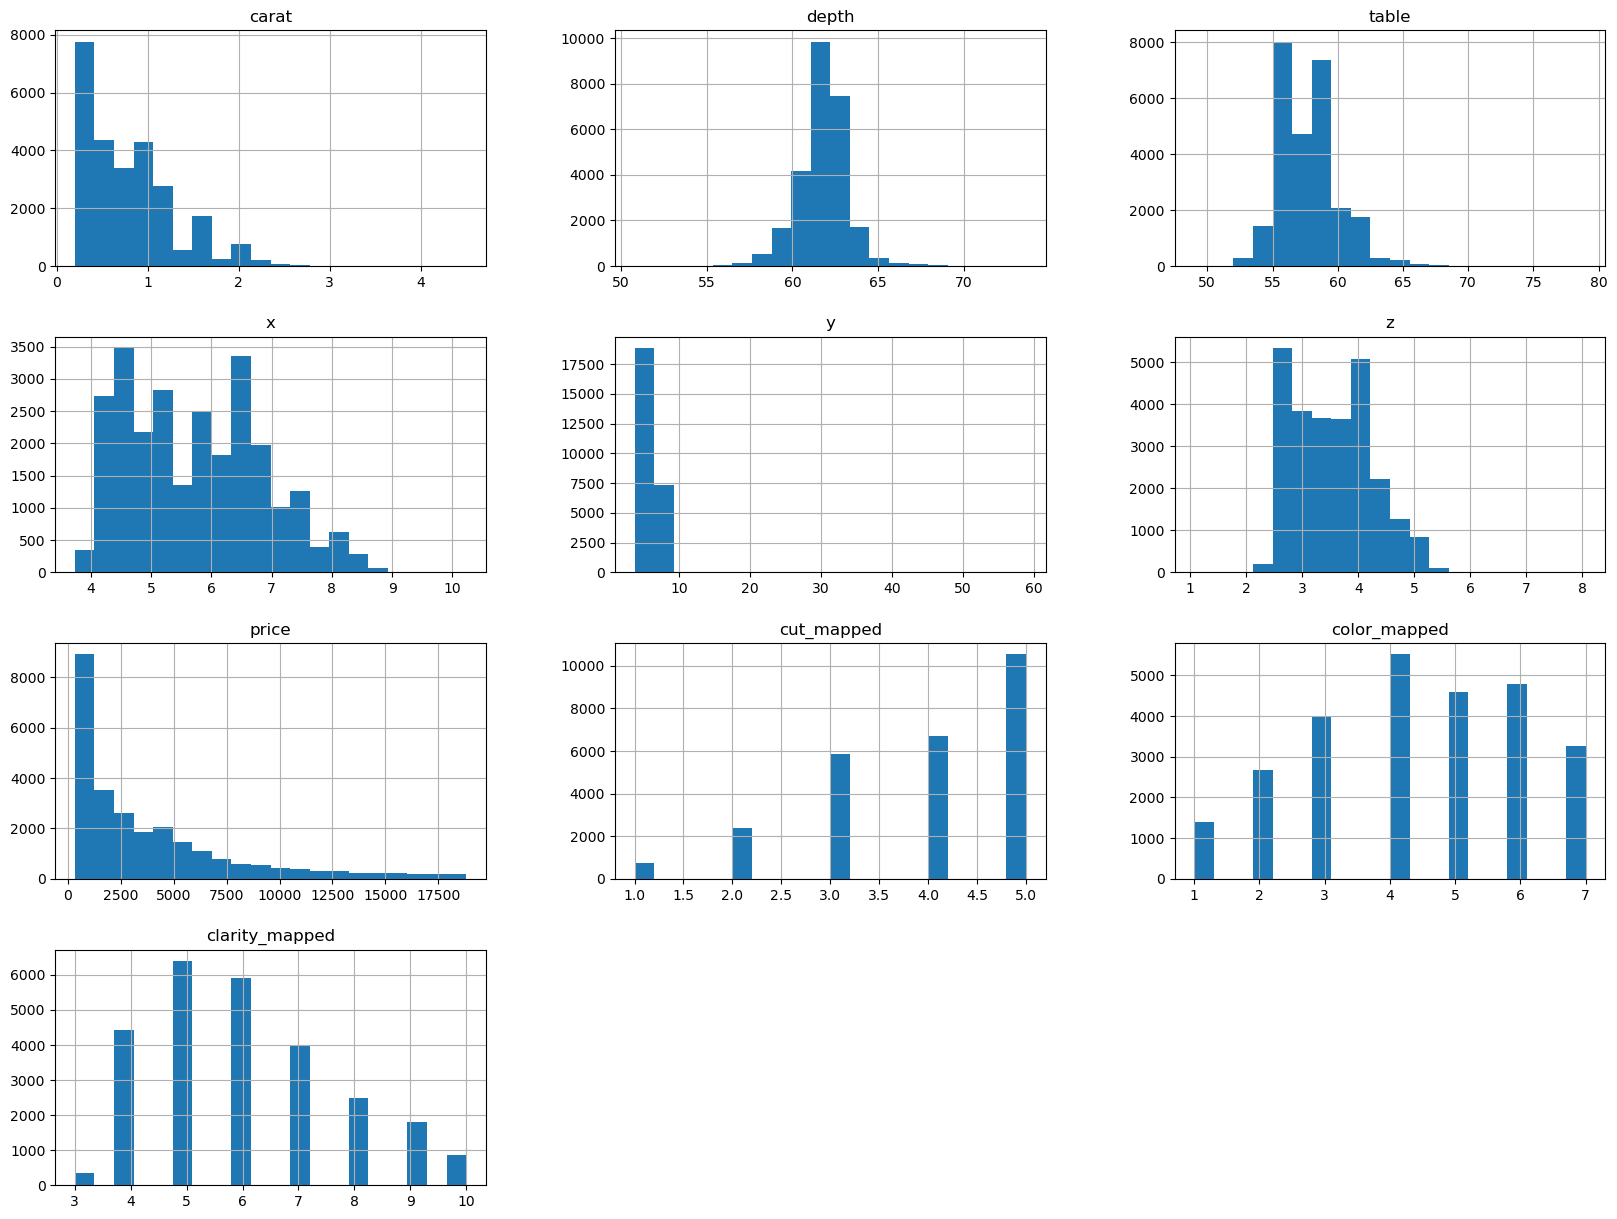

In [34]:
df1.hist(bins=20, 
          figsize=(20,15))
plt.show()

- A lot of features are not following Gaussian distribution

Lets also check how well does the target correlates with features, as well as how all the features correlates among themselves

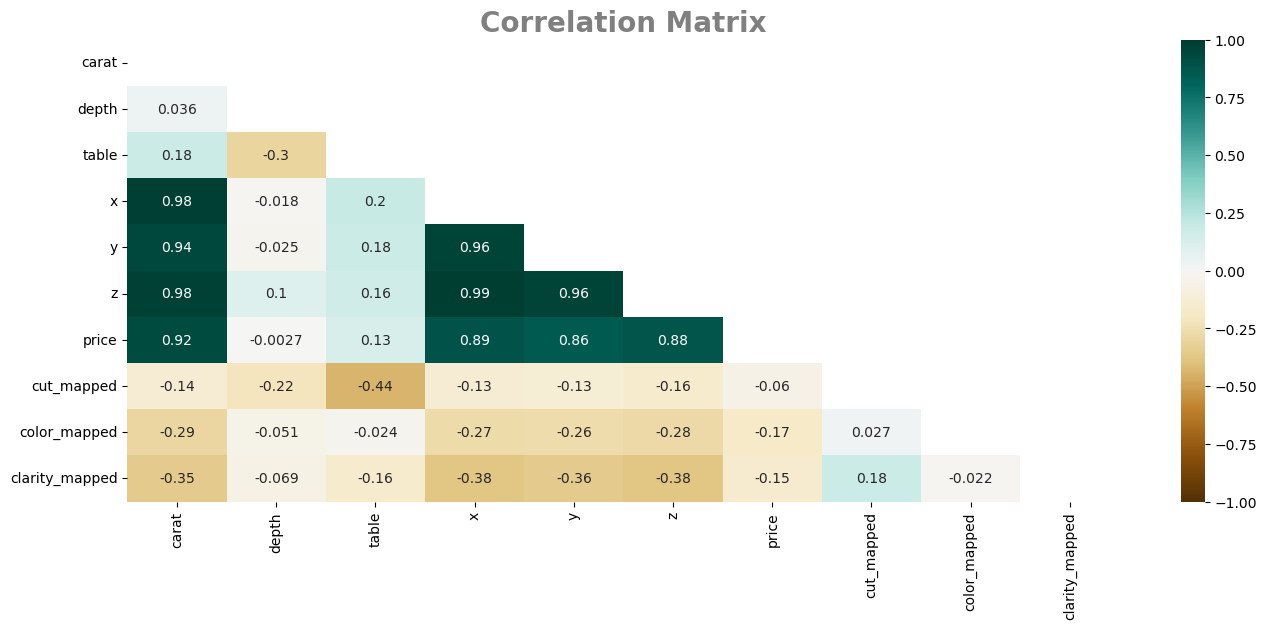

In [35]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df1.corr(), dtype=np.bool_))
sns.heatmap(df1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation Matrix', weight='bold', fontsize=20, color='gray')
plt.show()

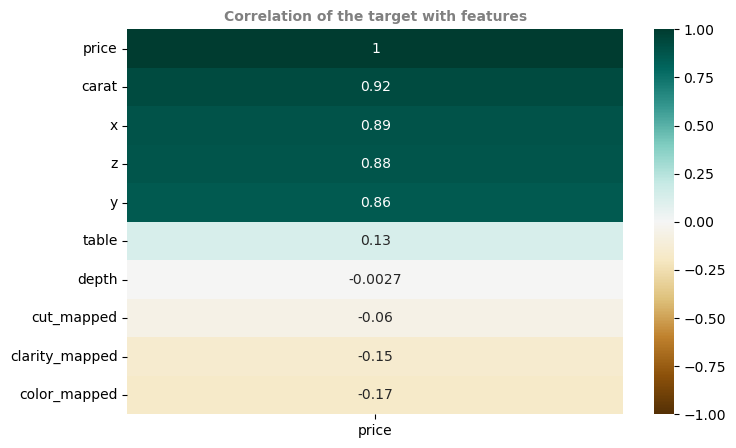

In [36]:
plt.figure(figsize=(8, 5))
sns.heatmap(df1.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation of the target with features', weight='bold', fontsize=10, color='gray')
plt.show()

- There are indeed some issues, such as 
    - Colinearity
    - Distribution of data that is not normal. 
    - Too many outliers in some of the features

---

## Modelling

To take care of the mentioned issues, I'd use tree based models such as Decision Trees, Random Forest, and XGBoost

In [37]:
# Features and Target of the dataset
X = df1.drop('price', axis=1)
y = df1['price']

In [38]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3)

In [39]:
# Instantiating of algorithms
models = []

# Appending multiple algorithms in a list
models.append(('decisiontrees_regressor', DecisionTreeRegressor()))
models.append(('randomforest_regressor', RandomForestRegressor()))
models.append(('xgb_regressor', XGBRegressor()))

In [40]:
for name, model in models:
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('{} r2 score is {}, and MAE is {}'.format(str(name).upper(), round(r2,4), round(mae, 4)))  
    print('-'*65)

DECISIONTREES_REGRESSOR r2 score is 0.9652, and MAE is 380.0327
-----------------------------------------------------------------
RANDOMFOREST_REGRESSOR r2 score is 0.9799, and MAE is 282.3458
-----------------------------------------------------------------
XGB_REGRESSOR r2 score is 0.9796, and MAE is 288.1296
-----------------------------------------------------------------


- With R2, all the tree models performed very well on predicting price. 
- Looking back at the distribution of data, it must be recalled that our target variable is highly left skewed, that means that a lot of prices are expected to be smaller amounts (lying within USD 1500). In such cases, having an MAE of 287 is concerning. 
- Therefore, further investigation is necessary to check how model performs on smaller amounts

In [41]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('This RandomForestRegressors\' r2 score is {}, and MAE is {}'.format(round(r2,4), round(mae, 4)))  

This RandomForestRegressors' r2 score is 0.9798, and MAE is 282.5877


<Figure size 100x300 with 0 Axes>

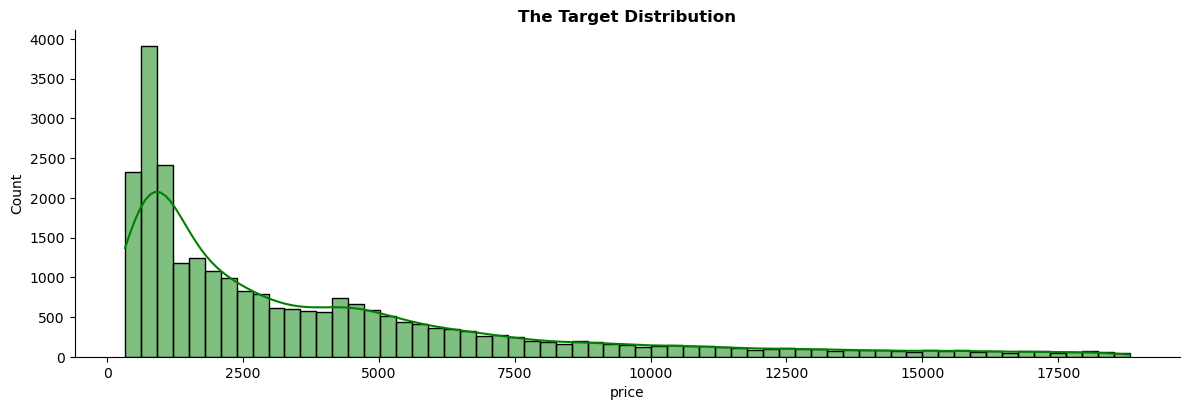

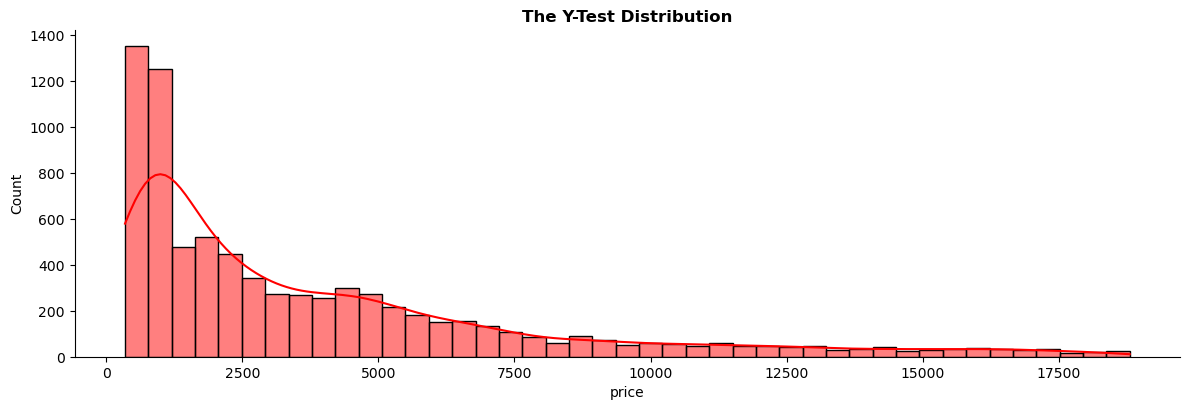

In [42]:
# The Target Variable
plt.figure(figsize=(1,3))
sns.displot(df, x='price', color='green', kde=True, height=4, aspect=3)
plt.title('The Target Distribution', weight='bold')

sns.displot(y_test, kde=True, color='red', height=4, aspect=3)
plt.title('The Y-Test Distribution', weight='bold')
plt.show()


- The test set, apparently, fairly represents the real target values

In [43]:
# Zipping the actual and predicted together in a dict
dict_comparison = dict(zip(y_test, y_pred))

# Converting the zipped dictionary into a dataframe
df_comparison = pd.DataFrame(dict_comparison.items())

# Assigning the column names,  sorting wrt Actual, and reseting the index
df_comparison.columns = ['Actual', 'Predicted']
df_comparison = df_comparison.sort_values(by='Actual').reset_index(drop=True)

df_comparison.head()


Actual  Predicted
0     345     458.46
1     351     385.44
2     357     457.86
3     363     391.28
4     364     405.87

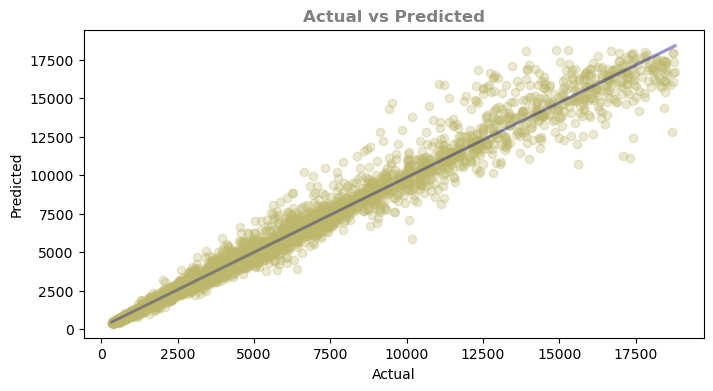

In [44]:
plt.figure(figsize=(8,4))
sns.regplot(x='Actual',
            y='Predicted', 
            data = df_comparison, 
            scatter_kws = {'color': 'darkkhaki', 'alpha': 0.3}, 
            line_kws = {'color': 'navy', 'alpha': 0.3})
plt.title('Actual vs Predicted', weight='bold', color='gray')
plt.show()

The results show that for lower actual values, the Absolute error is indeed smaller, and the error is roughly propotional to the size of target value. 

In [47]:
# Saving the model for predictions 
joblib.dump(model, 'model.sav')

['model.sav']